# Pairs trading. Pairs selection. Distance (Part 2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# read prices from csv file
prices = pd.read_csv('vbr16_19.csv', index_col='Date')

In [3]:
prices

,IEX,NUAN,MOH,NVAX,SBNY,PWR,WSM,FANG,BRO,STLD,...,RES,LE,APEI,FF,WK,PKI,ALGT,SAGE,OII,DRQ
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,76.976616,13.567100,49.830002,149.800003,116.435783,22.887882,45.972996,85.069756,17.572161,21.910513,...,14.904593,16.760000,28.219999,5.362969,13.470000,51.718643,138.262650,31.100000,29.461021,59.099998
2016-07-05,75.590309,13.134199,48.240002,144.600006,113.829865,22.759472,44.250740,84.120781,17.387442,21.884090,...,14.506883,16.330000,26.690001,5.353037,13.450000,51.119549,134.303772,31.280001,28.251621,56.540001
2016-07-06,76.311562,13.151515,48.669998,149.199997,115.586044,23.174353,44.882534,85.032166,17.486902,22.482931,...,14.459538,16.100000,27.570000,5.372900,13.400000,51.512394,135.205246,32.320000,28.464476,56.830002
2016-07-07,76.798637,13.376623,48.959999,149.199997,117.115601,23.371920,44.666168,83.237549,17.425331,22.755930,...,14.345906,16.170000,27.799999,5.333174,13.560000,51.649891,135.381775,32.160000,28.396748,56.889999
2016-07-08,78.540871,13.722944,50.209999,152.399994,119.003944,24.063398,46.855759,83.773125,17.685837,23.460453,...,14.648921,16.700001,28.629999,5.556631,13.860000,52.985580,137.705048,33.970001,28.812782,57.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,170.038528,18.010000,136.649994,4.000000,131.962463,40.950520,70.886360,84.531479,38.795483,32.447666,...,5.050000,17.809999,27.330000,7.557316,41.470001,96.798271,179.097549,74.639999,15.090000,47.389999
2019-12-24,168.596710,18.000000,136.240005,4.000000,132.428436,40.712379,70.472260,85.623375,38.637653,32.664612,...,5.030000,17.580000,27.430000,7.600537,42.009998,97.037254,179.187057,76.800003,15.140000,47.410000
2019-12-26,169.420593,18.049999,136.380005,4.000000,133.185608,40.920746,71.271553,86.696274,38.834934,32.721199,...,5.110000,18.295000,27.910000,7.705499,41.740002,96.758453,177.973587,74.160004,15.090000,47.840000


In [4]:
cumret = np.log(prices).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True) 

# Functions to calculate different metrics

In [5]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint
    
    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]
    
    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    
    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread) < 2*hist_sd).sum() / len(spread) * 100
        
    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

## 12 months formation period \ 6 months trading period

In [6]:
# prepare data
cumret12_6 = cumret.loc['2018-07-01':]
cumret12_6 = cumret12_6 / cumret12_6.iloc[0] # divide by first row so that all prices start at 1
train12_6 = cumret12_6.loc['2018-07-01':'2019-06-31'] # formation period
test12_6 = cumret12_6.loc['2019-07-01':'2019-12-31'] # trading period

In [9]:
def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller

    cols = ['Euclidean distance', 'Num zero-crossings', 'Pearson r', 
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested) and (f'{s2}-{s1}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = cadf_pvalue(s1,s2,train)
                if cadf_p<0.01:
                    spread = train[s1] - train[s2]
                    hurst = compute_Hc(spread)[0]
                    if hurst<0.5:
                        halflife = calculate_halflife(spread)
                        if halflife>1 and halflife<30:
                            num_crossings = (spread.values[1:] * spread.values[:-1] < 0).sum()
                            if num_crossings>len(train.index)/252*12: 
                                distance = np.sqrt(np.sum((train[s1] - train[s2])**2)) # Euclidean distance
                                pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                spread_sd = spread.std()
                                pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r,
                                                           spread_sd, hurst, halflife]
                                
    return pairs

In [ ]:
pairs12_6 = select_pairs(train12_6)

In [12]:
pairs12_6

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
IEX-MUSA,0.816384,27.0,0.718885,0.035409,0.337699,8.310141
IEX-CNMD,0.725404,15.0,0.919673,0.026183,0.363665,6.945197
MOH-MIDD,1.245225,18.0,0.676203,0.078861,0.377194,17.776041
MOH-AIN,1.082344,17.0,0.720492,0.042394,0.271084,6.649536
SBNY-BLMN,1.485248,16.0,0.462121,0.065425,0.395221,10.940311
...,...,...,...,...,...,...
CMO-ALGT,0.861636,23.0,0.809393,0.050478,0.269753,5.927857
PAHC-TG,0.906043,24.0,0.891688,0.045557,0.281683,5.266284
HTLD-GRC,0.663265,25.0,0.583901,0.035531,0.233136,5.210534
TG-EBIX,1.154516,15.0,0.920364,0.063460,0.306991,8.131903


## Shortest distance

In [39]:
pairs12_6.sort_values(by='Euclidean distance')

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
BXMT-PMT,0.185347,31.0,0.979720,0.010702,0.317424,3.574730
CBSH-CVBF,0.231623,23.0,0.937440,0.012397,0.385377,5.819853
CFR-SHO,0.279678,35.0,0.941726,0.014308,0.236291,2.956200
CUZ-HPP,0.293363,29.0,0.947128,0.016266,0.293839,5.851847
PACW-HOMB,0.297277,40.0,0.981729,0.017245,0.329704,5.307125
...,...,...,...,...,...,...
MAT-AAWW,6.088166,15.0,0.920937,0.259785,0.479398,19.778226
SABR-BKD,6.176396,13.0,0.869207,0.262997,0.391234,27.110238
AAL-BKD,6.327497,15.0,0.739510,0.278521,0.432308,27.703807
FFIV-BKD,6.739074,19.0,0.796772,0.278750,0.411789,27.314944


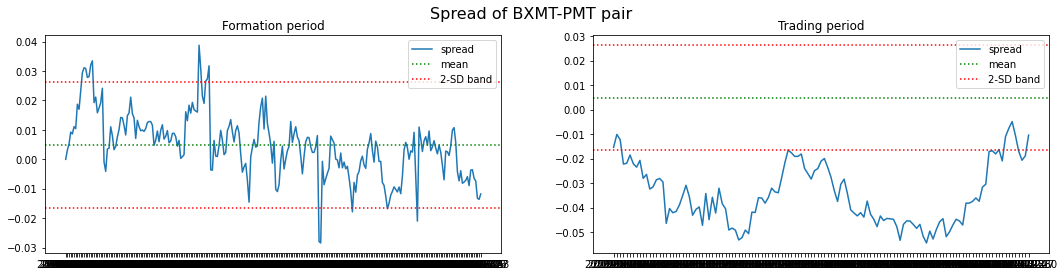

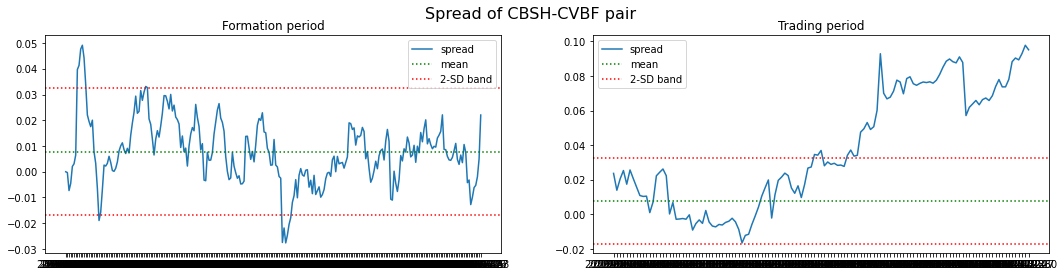

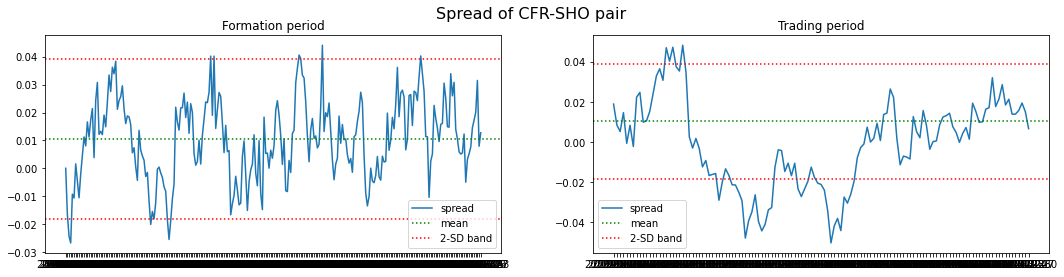

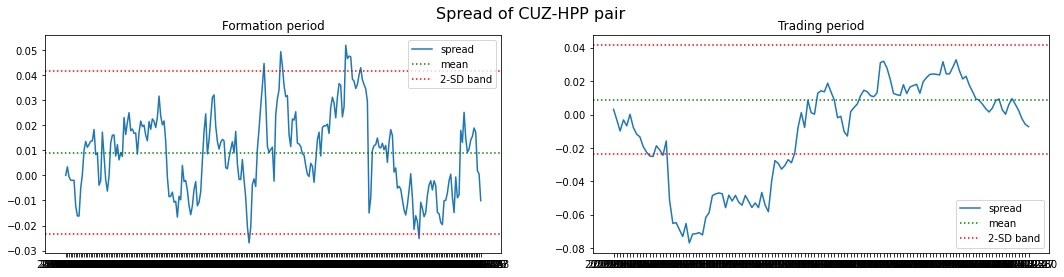

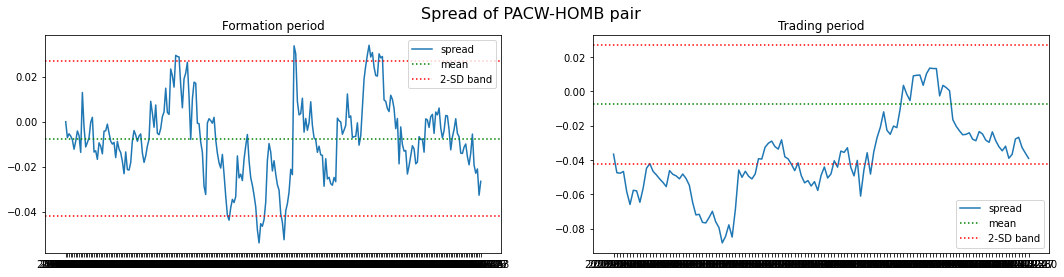

In [14]:
top5_distance = list(pairs12_6.sort_values(by='Euclidean distance').index[:5])
plot_pairs(top5_distance, train12_6, test12_6)

In [15]:
calculate_metrics(top5_distance, test12_6, pairs12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
BXMT-PMT,0.412001,0.342681,0.147309,0.010702,0.809057,0,0.39562,9.363208,19.685039
CBSH-CVBF,0.569369,0.005272,0.868795,0.012397,0.818829,6,0.643906,59.468393,44.094488
CFR-SHO,0.250588,0.177118,0.143363,0.014308,0.776006,14,0.422028,8.101202,78.740157
CUZ-HPP,0.369421,0.500724,0.637339,0.016266,0.820721,9,0.560733,27.359519,73.228346
PACW-HOMB,0.501804,0.211695,0.37239,0.017245,0.838157,6,0.483494,14.748714,38.582677


## Highest number of zero crossings

In [40]:
pairs12_6.sort_values(by='Num zero-crossings', ascending=False)

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
WEN-MGEE,0.402157,56.0,0.803878,0.024737,0.356290,4.969020
BCO-UBA,0.507256,54.0,0.814123,0.029221,0.283662,5.598683
MDU-WERN,0.374372,53.0,0.827682,0.023389,0.410667,3.239831
UMPQ-CAKE,0.575611,51.0,0.875556,0.032795,0.315820,5.124627
ATO-CVI,0.445862,51.0,0.844580,0.027995,0.364941,4.866769
...,...,...,...,...,...,...
ATO-RGA,0.503619,12.0,0.702816,0.031576,0.392084,9.556011
FNB-SBRA,1.204311,12.0,0.780631,0.042271,0.428237,8.702971
TPR-ESI,2.696998,12.0,0.836634,0.098459,0.466081,29.512144
HOG-SXI,1.949528,12.0,0.859159,0.076012,0.470661,12.236650


In [17]:
top5_crossings = list(pairs12_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])

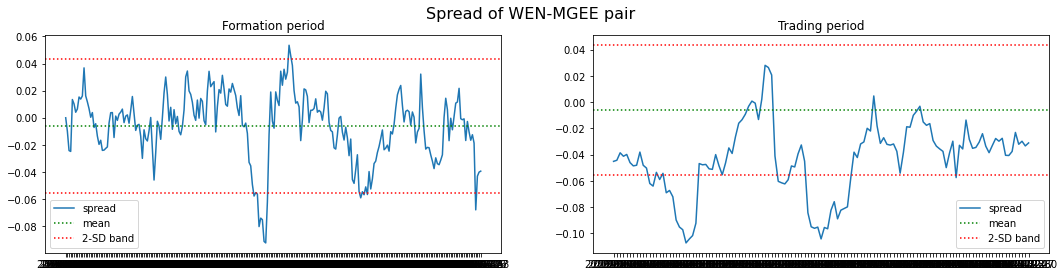

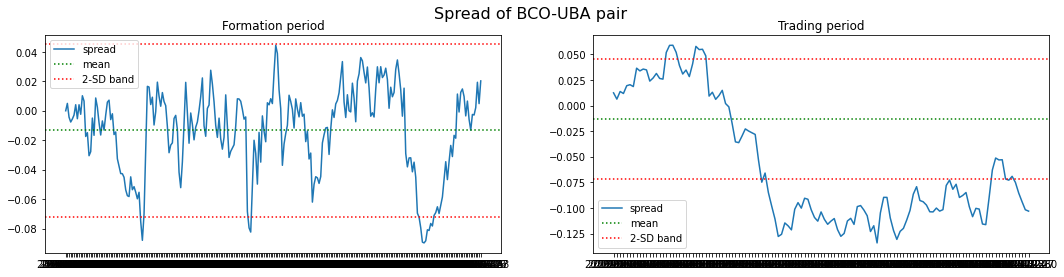

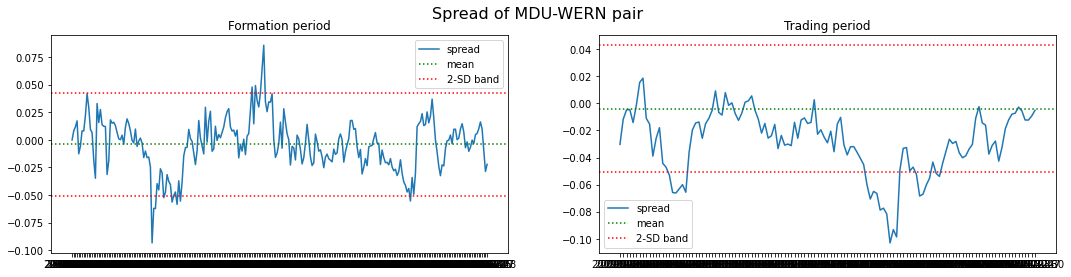

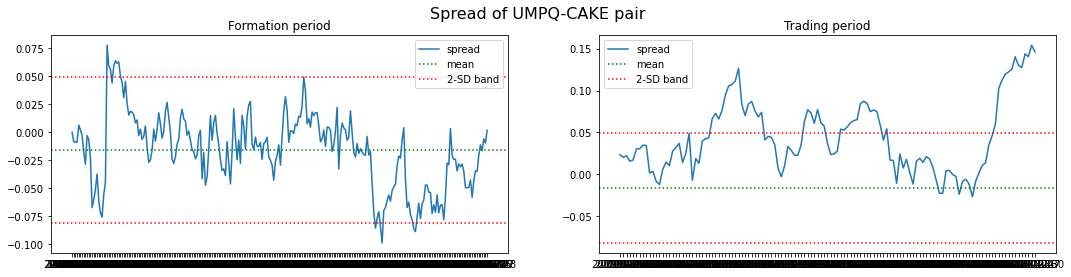

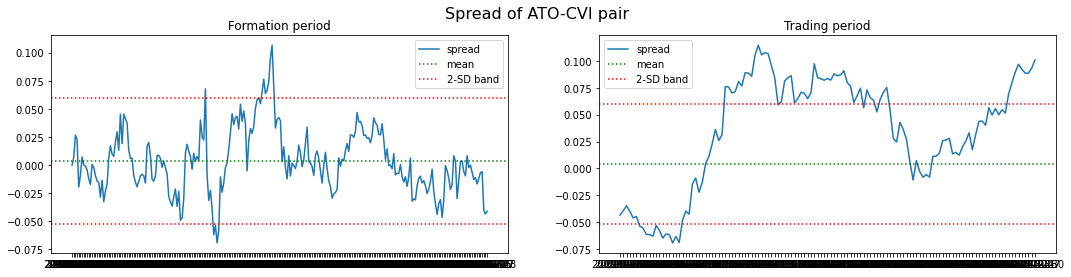

In [18]:
plot_pairs(top5_crossings, train12_6, test12_6)

In [19]:
calculate_metrics(top5_crossings, test12_6, pairs12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
WEN-MGEE,0.578938,0.180918,0.055752,0.024737,0.626841,6,0.430738,7.017354,68.503937
BCO-UBA,0.942231,0.60094,0.597414,0.029221,0.439827,1,0.609491,34.766309,36.220472
MDU-WERN,0.422077,0.170191,0.078412,0.023389,0.87252,12,0.379857,6.137746,78.740157
UMPQ-CAKE,0.689869,0.734501,0.578222,0.032795,0.450011,14,0.355778,14.767419,70.866142
ATO-CVI,0.710299,0.10734,0.593521,0.027995,-0.451995,5,0.571011,26.202676,45.669291


## Highest Pearson r

In [41]:
pairs12_6.sort_values(by='Pearson r', ascending=False)

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
PACW-HOMB,0.297277,40.0,0.981729,0.017245,0.329704,5.307125
BXMT-PMT,0.185347,31.0,0.979720,0.010702,0.317424,3.574730
HOMB-TOWN,0.475155,13.0,0.978838,0.028425,0.418823,12.726119
CPRI-OVV,1.358694,15.0,0.976840,0.054406,0.390055,6.545796
SNV-TILE,0.551646,21.0,0.975798,0.034835,0.397837,10.015588
...,...,...,...,...,...,...
LSI-CF,1.089818,17.0,-0.411486,0.067470,0.435746,20.753520
OTTR-DBRG,2.365099,19.0,-0.452685,0.107334,0.483697,28.454986
UAA-NPK,4.370257,22.0,-0.517490,0.260752,0.419702,26.938836
ATO-AAL,2.758238,12.0,-0.590159,0.104644,0.471169,28.526204


In [21]:
top5_pearson = list(pairs12_6.sort_values(by='Pearson r', ascending=False).index[:5])

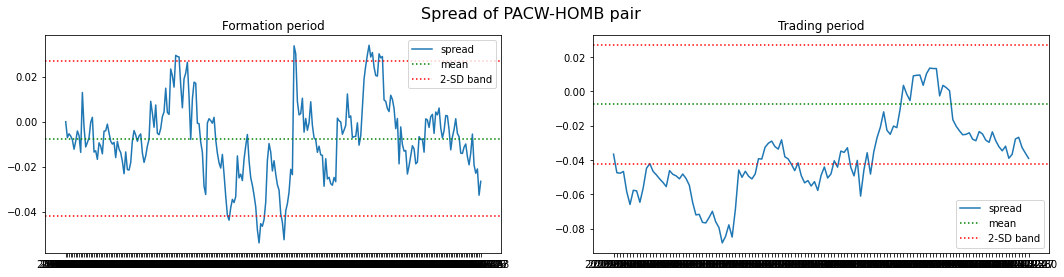

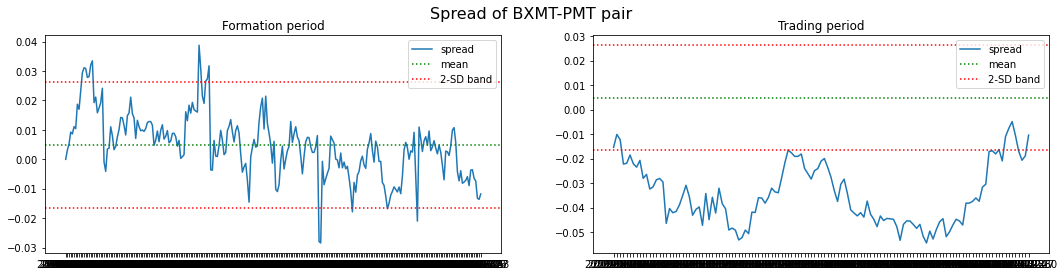

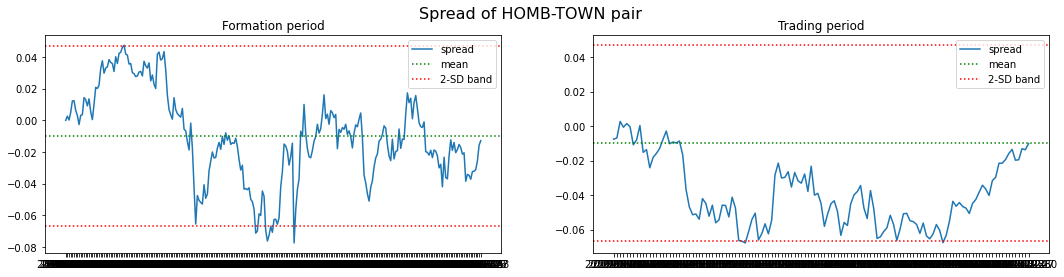

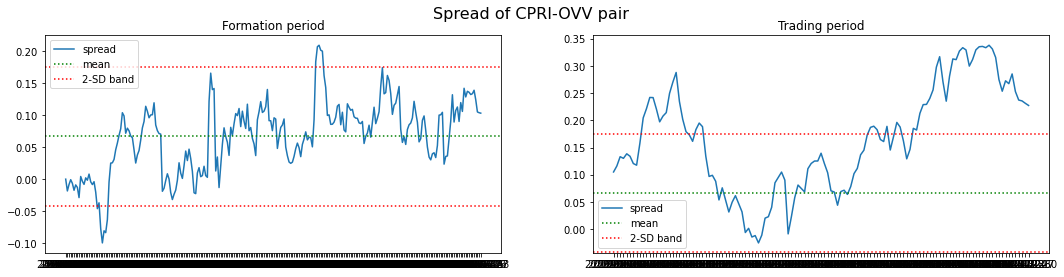

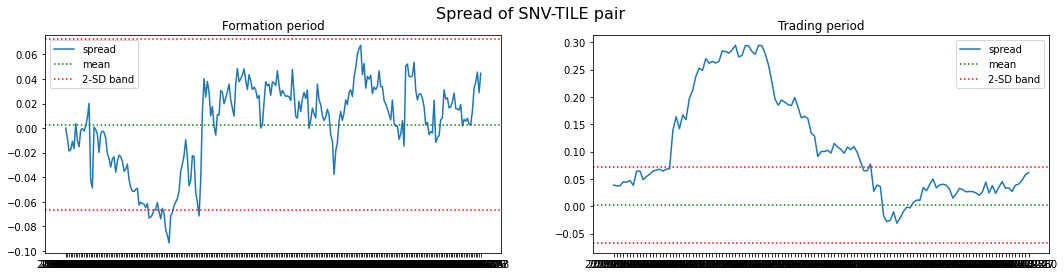

In [22]:
plot_pairs(top5_pearson, train12_6, test12_6)

In [23]:
calculate_metrics(top5_pearson, test12_6, pairs12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
PACW-HOMB,0.501804,0.211695,0.37239,0.017245,0.838157,6,0.483494,14.748714,38.582677
BXMT-PMT,0.412001,0.342681,0.147309,0.010702,0.809057,0,0.39562,9.363208,19.685039
HOMB-TOWN,0.493725,0.393915,0.174827,0.028425,0.760925,6,0.368705,8.7115,79.527559
CPRI-OVV,2.155158,0.038003,0.577172,0.054406,0.05946,6,0.438301,22.873936,31.496063
SNV-TILE,1.63176,0.528256,0.4205,0.034835,0.524282,2,0.652747,49.349589,53.543307


## 36 months formation period \ 6 months trading period

In [24]:
# prepare data
cumret36_6 = cumret.loc['2016-07-01':]
cumret36_6 = cumret36_6 / cumret36_6.iloc[0] # divide by first row so that all prices start at 1
train36_6 = cumret36_6.loc['2016-07-01':'2019-06-31'] # formation period
test36_6 = cumret36_6.loc['2019-07-01':'2019-12-31'] # trading period

In [25]:
pairs36_6 = select_pairs(train36_6)

In [26]:
pairs36_6

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
MOH-IRDM,4.604925,43.0,0.949122,0.123302,0.341237,17.816494
WSM-RPM,2.453847,66.0,0.779158,0.075694,0.406112,17.020147
WSM-RLI,3.148036,38.0,0.793763,0.088982,0.385926,20.033282
WSM-EGHT,4.197625,41.0,0.728658,0.135791,0.426406,29.808568
WSM-CXP,2.539110,36.0,0.686387,0.092644,0.400825,27.827446
...,...,...,...,...,...,...
TMP-MRC,2.636316,55.0,0.743047,0.095445,0.416476,22.479040
PBF-GES,4.530530,57.0,0.894771,0.137937,0.352879,17.889228
AXL-ACCO,3.476527,40.0,0.742802,0.123939,0.377708,21.891202
TILE-EBIX,1.822504,68.0,0.931721,0.066037,0.372971,11.158514


## Shortest distance

In [42]:
pairs36_6.sort_values(by='Euclidean distance')

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
AUB-BRKL,0.945428,58.0,0.966178,0.034478,0.345410,13.124251
BXS-CVBF,1.043964,46.0,0.948924,0.038083,0.357638,27.058791
AIT-HTLF,1.210360,63.0,0.961289,0.040817,0.276253,9.942151
ONB-BANR,1.268268,36.0,0.949244,0.039715,0.436052,20.020719
EQC-AIV,1.328059,43.0,0.901227,0.036940,0.386308,26.185496
...,...,...,...,...,...,...
CF-TRS,5.384216,40.0,0.931321,0.121119,0.409446,29.563381
HAIN-TGI,5.385300,44.0,0.815154,0.168878,0.349180,24.993171
MRO-CALM,5.514713,43.0,0.728780,0.134348,0.386407,26.255362
COTY-TGI,5.950220,39.0,0.830401,0.171751,0.396225,21.392597


In [43]:
top5_distance = list(pairs36_6.sort_values(by='Euclidean distance').index[:5])

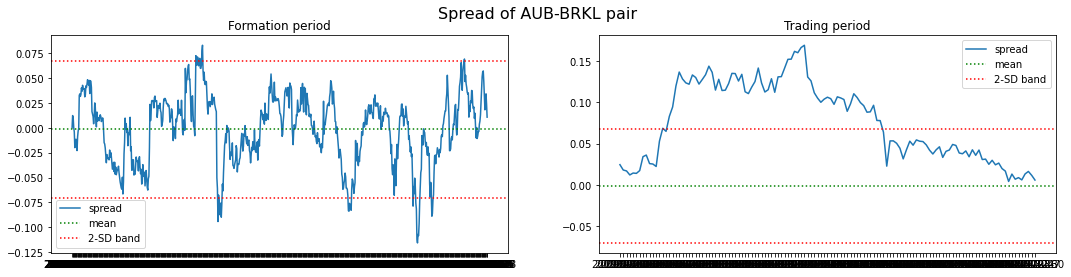

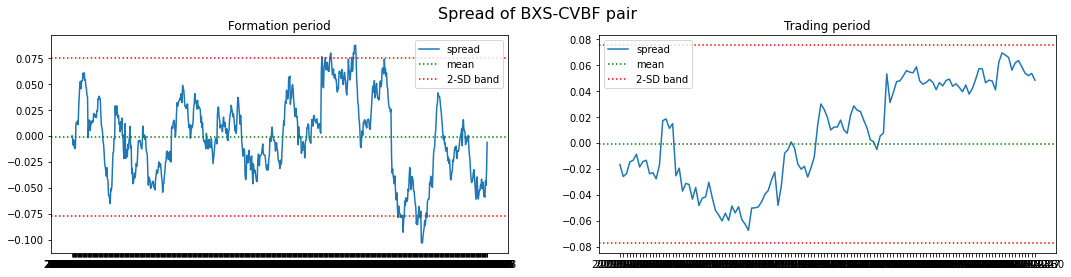

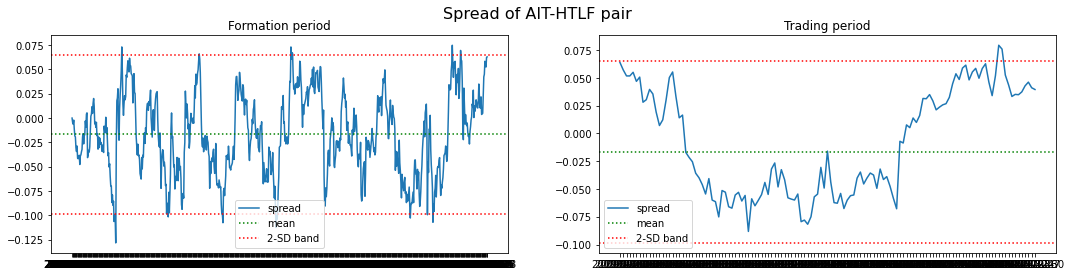

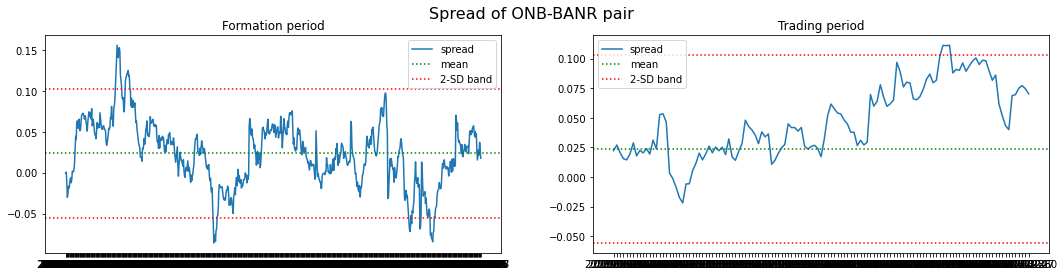

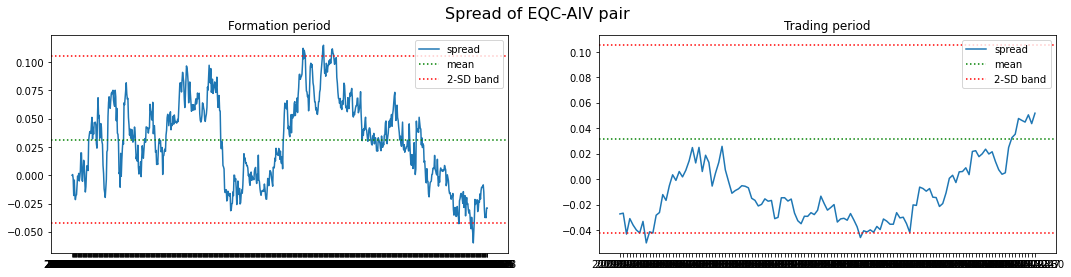

In [29]:
plot_pairs(top5_distance, train36_6, test36_6)

In [30]:
calculate_metrics(top5_distance, test36_6, pairs36_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
AUB-BRKL,1.019298,0.115545,0.716331,0.034478,0.630989,0,0.599827,30.390113,48.818898
BXS-CVBF,0.449441,0.007721,0.617381,0.038083,0.829352,7,0.555658,22.550187,100.0
AIT-HTLF,0.543911,0.158431,0.504379,0.040817,0.853593,2,0.510415,15.202802,98.425197
ONB-BANR,0.634614,0.07436,0.295722,0.039715,0.706635,2,0.480565,11.376194,79.527559
EQC-AIV,0.294428,0.807129,0.747521,0.03694,0.730938,9,0.512182,22.63311,100.0


## Highest number of zero crossings

In [44]:
pairs36_6.sort_values(by='Num zero-crossings', ascending=False)

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
PII-SEIC,1.862057,88.0,0.926157,0.063910,0.355263,12.528243
PII-TPH,2.530457,87.0,0.869808,0.083578,0.361739,16.333329
ABG-STFC,2.358393,84.0,0.849074,0.077553,0.387765,17.600865
CMC-SFNC,2.305409,83.0,0.861839,0.080451,0.357008,17.246534
FANG-HUBG,2.911177,76.0,0.703002,0.091253,0.342127,14.817709
...,...,...,...,...,...,...
NCLH-FULT,3.691585,36.0,0.733813,0.091742,0.416721,28.424910
JEF-WNC,3.356586,36.0,0.891050,0.106531,0.423911,27.689075
ONB-BANR,1.268268,36.0,0.949244,0.039715,0.436052,20.020719
SLGN-MDP,2.304409,36.0,0.518745,0.083843,0.379681,26.916516


In [32]:
top5_crossings = list(pairs36_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])

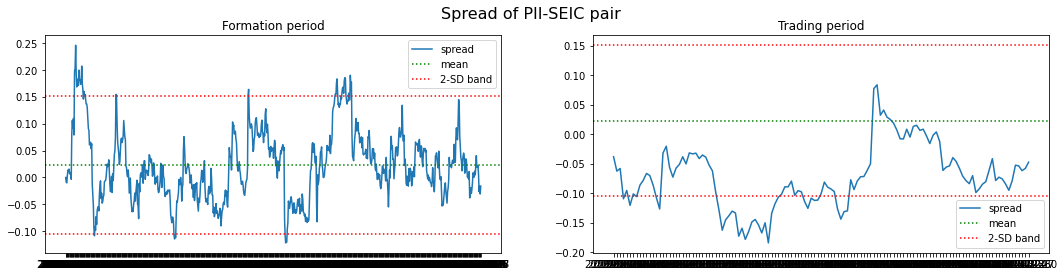

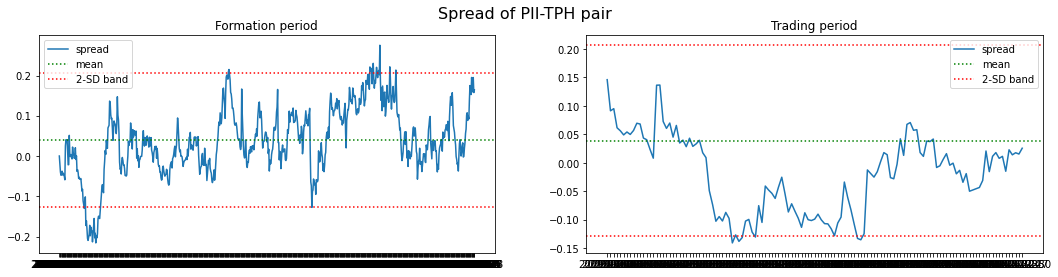

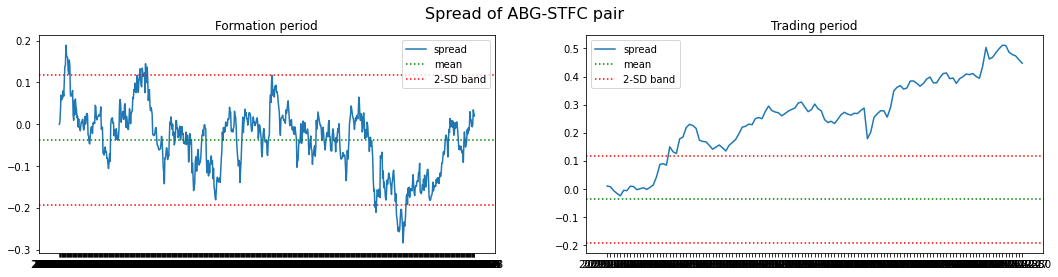

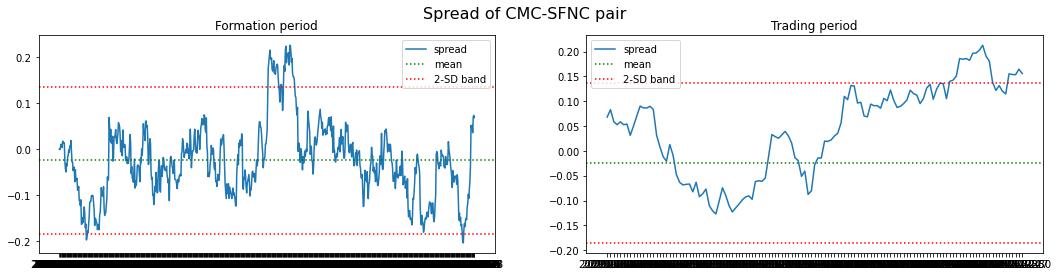

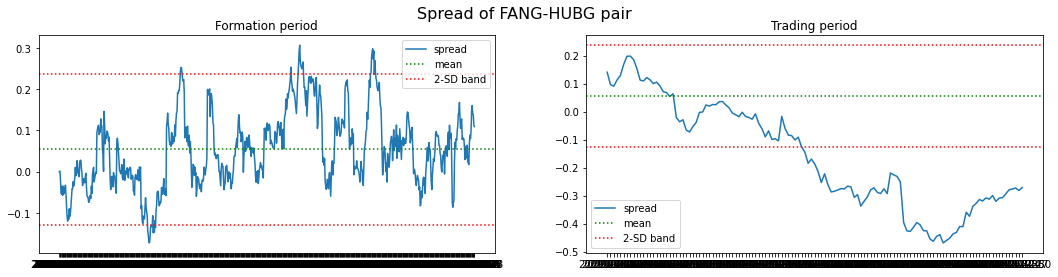

In [33]:
plot_pairs(top5_crossings, train36_6, test36_6)

In [34]:
calculate_metrics(top5_crossings, test36_6, pairs36_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
PII-SEIC,1.011441,0.182674,0.127835,0.06391,0.819782,8,0.473928,7.562963,84.251969
PII-TPH,0.797038,0.090041,0.040799,0.083578,0.678051,12,0.446656,6.755332,100.0
ABG-STFC,3.306285,0.106675,0.598077,0.077553,-0.684393,6,0.665404,40.958546,21.259843
CMC-SFNC,1.155885,0.197321,0.783691,0.080451,0.680381,6,0.545966,39.466817,91.338583
FANG-HUBG,2.793297,0.030777,0.538486,0.091253,-0.818249,3,0.702667,37.505324,46.456693


## Highest Pearson r

In [45]:
pairs36_6.sort_values(by='Pearson r', ascending=False)

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
VGR-DLX,1.384203,73.0,0.966216,0.050437,0.358141,10.673663
AUB-BRKL,0.945428,58.0,0.966178,0.034478,0.345410,13.124251
ITT-SKYW,2.857817,52.0,0.964193,0.088827,0.391791,23.230473
AIT-HTLF,1.210360,63.0,0.961289,0.040817,0.276253,9.942151
SIGI-AIN,1.989952,36.0,0.959764,0.062851,0.389686,18.913789
...,...,...,...,...,...,...
CAKE-EPAC,2.892740,65.0,0.528604,0.094941,0.440930,25.536853
SLGN-MDP,2.304409,36.0,0.518745,0.083843,0.379681,26.916516
NFG-CXP,2.006098,39.0,0.485537,0.054924,0.335437,20.606923
UVV-EPAC,3.023432,37.0,0.446938,0.105863,0.368837,23.826835


In [36]:
top5_pearson = list(pairs36_6.sort_values(by='Pearson r', ascending=False).index[:5])

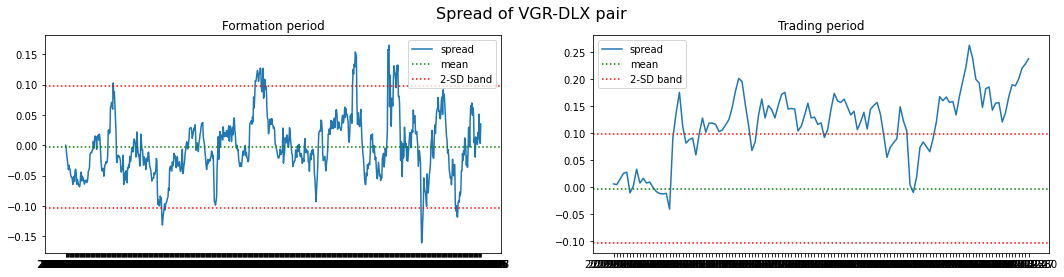

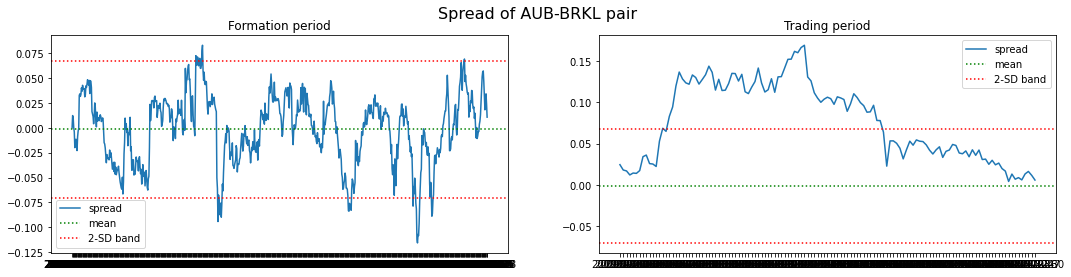

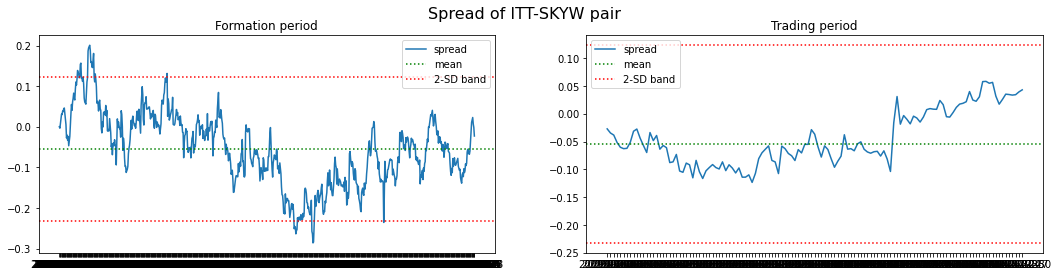

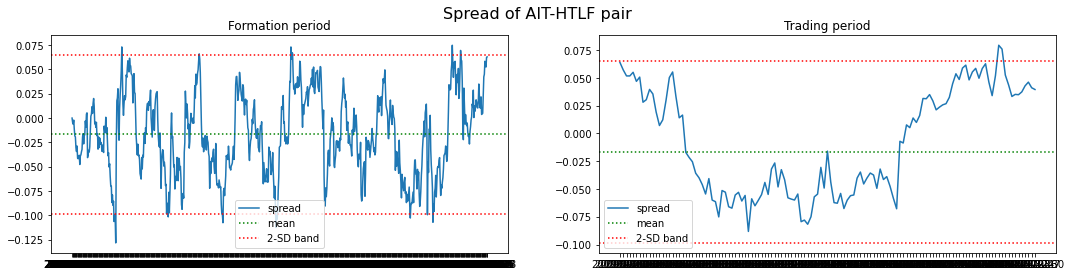

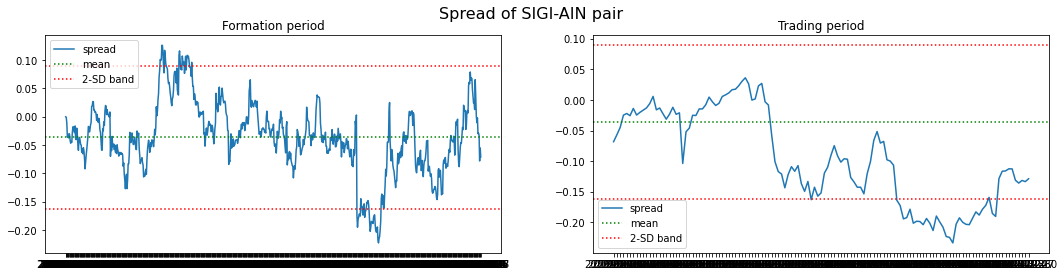

In [37]:
plot_pairs(top5_pearson, train36_6, test36_6)

In [38]:
calculate_metrics(top5_pearson, test36_6, pairs36_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
VGR-DLX,1.495968,0.006527,0.031277,0.050437,0.905911,6,0.387964,6.769705,31.496063
AUB-BRKL,1.019298,0.115545,0.716331,0.034478,0.630989,0,0.599827,30.390113,48.818898
ITT-SKYW,0.745466,0.000477,0.81896,0.088827,0.944523,5,0.45543,13.27288,100.0
AIT-HTLF,0.543911,0.158431,0.504379,0.040817,0.853593,2,0.510415,15.202802,98.425197
SIGI-AIN,1.37752,0.480559,0.599517,0.062851,0.094241,8,0.453092,23.272512,60.629921
